In [1]:
from glob import glob
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve

In [2]:
def cleavage(x):
    try:
        return int(x.split('..')[1].split(';')[0])
    except Exception:
        if str(x) != 'nan':
            print(x)
        return np.nan

In [3]:
benchmark_set = pd.read_csv('../data/media/benchmark_sp_new.tsv.gz', sep='\t')

benchmark_neg = benchmark_set[~benchmark_set['Signal peptide']\
                              .apply(lambda x: 'SIGNAL' in str(x))].copy()
benchmark_neg.insert(0, 'Label', 0)

benchmark_pos = benchmark_set[benchmark_set['Signal peptide']\
                              .apply(lambda x: '0000269' in str(x))].copy()
benchmark_pos.insert(0, 'Label', 1)

benchmark_set = pd.concat([benchmark_pos, benchmark_neg]).reset_index(drop=True)
benchmark_set['Cleav'] = benchmark_set['Signal peptide'].apply(cleavage)

In [4]:
animal_toxins = pd.read_csv('../data/uniprot/Animal_Toxin_Annotation_Project/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2022.10.18-22.01.29.50.tsv.gz', sep='\t')
toxin_kw = pd.read_csv('../data/uniprot/Toxin_Keyword/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2022.10.18-22.02.27.32.tsv.gz', sep='\t')
toxins = pd.concat([animal_toxins, toxin_kw]).drop_duplicates('Entry')
benchmark_toxins = pd.read_csv('../data/media/benchmark_toxins.csv.1c539a7e.gz')
benchmark_toxins = pd.merge(benchmark_toxins[['Entry']], toxins, on='Entry')

toxins.insert(0, 'Toxin', 1)
toxins = pd.merge(benchmark_set,toxins[['Entry','Toxin']], on='Entry')

benchmark_set.insert(0, 'Toxin', 0)
benchmark_set = pd.concat([toxins, benchmark_set]).drop_duplicates('Entry')

In [5]:
benchmark_set.value_counts('Label')

Label
0    51982
1      295
dtype: int64

In [6]:
benchmark_set.value_counts('Toxin')

Toxin
0    49774
1     2503
dtype: int64

In [7]:
benchmark_set[(benchmark_set.Label==1) & (benchmark_set.Toxin==1)].shape

(96, 26)

In [8]:
def sp5_cleavage(val):
    try:
        cs = int(val.split('CS pos: ')[1].split('-')[0])
    except Exception:
        cs = np.nan
    return cs

# SignalP 4.0
sp4_cols = pd.read_csv('../data/media/benchmark0_summary.signalp4', skiprows=1, sep='\s+').columns[1:]
sp4 = pd.concat([pd.read_csv(i, comment='#', sep='\s+', header=None) 
                 for i in glob('../data/media/*.signalp4')])
sp4.columns = sp4_cols
sp4['Prob_SP4'] = sp4.D.astype(float)
sp4['Cleav_SP4'] = sp4.pos.apply(int) -1
sp4['Preds_SP4'] = sp4['?'].apply(lambda x: 1 if x == 'Y' else 0)
sp4['Entry'] = sp4.name.str.split('|').apply(lambda x: x[1])

# SignalP 5.0
sp5 = pd.concat([pd.read_csv(i, skiprows=1, sep='\t')
                 for i in glob('../data/media/*.signalp5')])
sp5['Prob_SP5'] = sp5['SP(Sec/SPI)'].astype(float)
sp5['Cleav_SP5'] = sp5['CS Position'].apply(sp5_cleavage)
sp5['Preds_SP5'] = sp5['Prediction'].apply(lambda x: 1 if x == 'SP(Sec/SPI)' else 0)
sp5['Entry'] = sp5['# ID'].str.split('|').apply(lambda x: x[1])

# # SignalP 6.0
# sp6 = pd.concat([pd.read_csv(i, sep='\t', skiprows=1) for i in
#                  glob('../data/media/signalp6_out/benchmark[0-9]/prediction_results.txt')]).drop_duplicates()
# sp6['Prob_SP6'] = sp6['SP(Sec/SPI)'].astype(float)
# sp6['Cleav_SP6'] = sp6['CS Position'].apply(sp5_cleavage)
# sp6['Preds_SP6'] = sp6['Prediction'].apply(lambda x: 1 if x == 'SP' else 0)
# sp6['Entry'] = sp6['# ID'].str.split('|').apply(lambda x: x[1])

# DeepSig
ds = pd.read_csv('../data/media/benchmark_sp_new.deepsig', sep='\t', header=None)
ds = ds.drop_duplicates(0)
ds.columns = ['Entry', 'Tool', 'Result', 3, 'Cleav_DeepSig', 'Prob_DeepSig', 6, 7, 8]
ds['Prob_DeepSig'] = ds['Prob_DeepSig'].astype(float, errors='ignore').apply(lambda x: 0 if x == '.' else x)
ds['Preds_DeepSig'] = ds['Result'].apply(lambda x: 1 if x =='Signal peptide' else 0)
ds['Prob_DeepSig'] = ds['Prob_DeepSig'].astype(float)
ds['Entry'] = ds.Entry.str.split('|').apply(lambda x: x[1])

# Razor
razor = pd.read_csv('../data/media/benchmark_sp_new_razor.csv', sep='\t')
razor['Entry'] = razor.Accession.str.split('|').apply(lambda x: x[1])

In [9]:
sp = pd.merge(sp4[['Entry','Cleav_SP4','Prob_SP4','Preds_SP4']],
              sp5[['Entry','Cleav_SP5','Prob_SP5','Preds_SP5']], on='Entry')
# sp = pd.merge(sp, sp6[['Entry','Cleav_SP6','Prob_SP6','Preds_SP6']], on='Entry')
sp = pd.merge(sp, ds[['Entry','Cleav_DeepSig','Prob_DeepSig','Preds_DeepSig']], on='Entry')
sp = pd.merge(sp, razor[['Entry','Cleavage after residue','Y_score','SP_score','Toxin_Scores','Toxin_scores_Median','Fungi_scores_Median']], on='Entry')

new = pd.merge(benchmark_set, sp, on='Entry')

In [10]:
# 2021 data 
benchmark_sp_new = pd.read_csv('../results/benchmark_sp_new.csv.gz')
new_toxins_nontoxins = pd.read_pickle('new_toxins_nontoxins.pkl.gz')

new = pd.merge(benchmark_sp_new[['Entry']], new, on='Entry')

In [11]:
# sp6_entries = pd.read_csv('../data/signalp6/train_set.fasta', sep='>', lineterminator='>', header=None)[0]\
# .str.split('|').apply(lambda x: x[0])
# sp6_entries = pd.DataFrame(sp6_entries)
# sp6_entries.columns = ['Entry']
# sp6_entries = pd.merge(new, sp6_entries, on='Entry')

# new = pd.concat([sp6_entries, new]).drop_duplicates('Entry',keep=False)
new.Label.value_counts()

0    51974
1      295
Name: Label, dtype: int64

In [12]:
signalp5_train_all = pd.read_pickle('../results/signalp5_train_all.pkl.gz')
toxin_nontoxin = pd.read_pickle('../results/toxin_nontoxin.pkl.gz')
training_ = pd.merge(pd.concat([toxin_nontoxin[['Entry']], signalp5_train_all[['Entry']]]).drop_duplicates(),\
        new, on='Entry')

new = pd.concat([training_, new]).drop_duplicates('Entry', keep=False)
new.Label.value_counts()

0    51950
1      250
Name: Label, dtype: int64

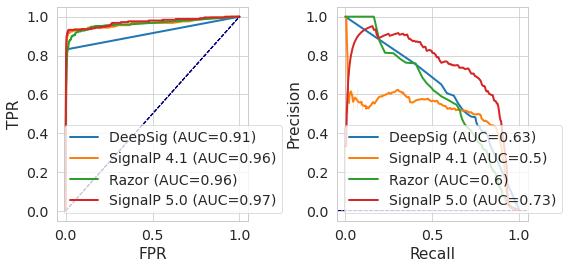

In [13]:
cols = ['Prob_DeepSig', 'Prob_SP4', 'SP_score', 'Prob_SP5']
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0']
labels = ['Label', 'Label', 'Label', 'Label', 'Label']


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),)

for i, v in enumerate(cols):

    preds = new[v].fillna(0)
    y = new[labels[i]]

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=ax[0], lw=2)
    #baseline
    ax[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=ax[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    ax[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')



    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')


fig.tight_layout()
# print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);

In [14]:
new['Preds_Razor'] = new.Y_score.str.replace('\[|\]','',regex=True).str.split(', ')\
.apply(lambda x: 0 if np.min(np.array(x).astype(np.float64)) <= 0.57 else 1)

new['Preds_Razor'].value_counts()

0    51260
1      940
Name: Preds_Razor, dtype: int64

<AxesSubplot:>

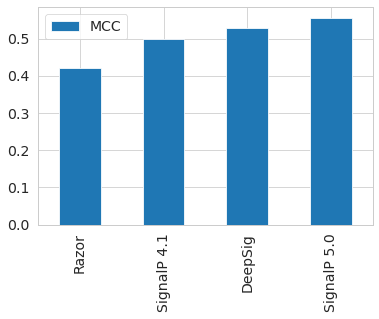

In [15]:
for_mcc = ['Preds_Razor', 'Preds_SP4', 'Preds_SP5','Preds_DeepSig']
mcc_df = pd.DataFrame(columns=['Razor', 'SignalP 4.1', 'SignalP 5.0','DeepSig'], index=['MCC'])
labels = ['Label', 'Label', 'Label', 'Label']
# new = tmp3.copy()

for i, v in enumerate(mcc_df.columns):
    mcc_df.loc['MCC', v] = matthews_corrcoef(new[labels[i]], new[for_mcc[i]])

mcc_df.transpose().sort_values(by='MCC').plot(kind='bar')

In [16]:
mcc_df

,Razor,SignalP 4.1,SignalP 5.0,DeepSig
MCC,0.422547,0.499472,0.557103,0.529959


In [17]:
# new = tmp3.copy()

cleavage_precision = []
cleavage_recall = []


# Razor
new['Diff'] = np.abs(new['Cleav'] - new['Cleavage after residue'])
false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_Razor'] == 1].copy()
true_n = false[false['Preds_Razor'] == 0].copy()

false_n = true[true['Preds_Razor'] == 0].copy()
true_p = true[true['Preds_Razor'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_Razor'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# SignalP4
new['Diff'] = np.abs(new['Cleav_SP4']  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_SP4'] == 1].copy()
true_n = false[false['Preds_SP4'] == 0].copy()

false_n = true[true['Preds_SP4'] == 0].copy()
true_p = true[true['Preds_SP4'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_SP4'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# SignalP5
new['Diff'] = np.abs(new['Cleav_SP5']  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_SP5'] == 1].copy()
true_n = false[false['Preds_SP5'] == 0].copy()

false_n = true[true['Preds_SP5'] == 0].copy()
true_p = true[true['Preds_SP5'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_SP5'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# # SignalP6
# new['Diff'] = np.abs(new['Cleav_SP6']  - new['Cleav'])

# false = new[new['Label'] == 0].copy()
# true = new[new['Label'] == 1].copy()

# false_p = false[false['Preds_SP6'] == 1].copy()
# true_n = false[false['Preds_SP6'] == 0].copy()

# false_n = true[true['Preds_SP6'] == 0].copy()
# true_p = true[true['Preds_SP6'] == 1].copy()


# csS_ = true_p.Diff.value_counts()
# csp = pd.DataFrame()
# csp['Distance around the\nactual cleavage site'] = csS_.index.values
# csp['CS Precision'] = csS_.values/(new[new['Preds_SP6'] == 1].shape[0]) #true_p.shape[0]
# csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
# csp = csp.reset_index(drop=True)


# csS_ = true_p.Diff.value_counts()
# css = pd.DataFrame()
# css['Distance around the\nactual cleavage site'] = csS_.index.values
# css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
# css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
# css = css.reset_index(drop=True)


# blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2], 
#               'CS Precision':[0,0,0]})
# csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
# blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2], 
#               'CS Recall':[0,0,0]})
# css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


# cleavage_precision.append(csp)
# cleavage_recall.append(css)



# DeepSig
new['Diff'] = np.abs(new['Cleav_DeepSig'] - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_DeepSig'] == 1].copy()
true_n = false[false['Preds_DeepSig'] == 0].copy()

false_n = true[true['Preds_DeepSig'] == 0].copy()
true_p = true[true['Preds_DeepSig'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_DeepSig'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)

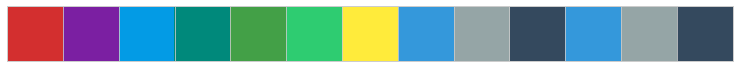

In [18]:
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]
sns.palplot(flatui)

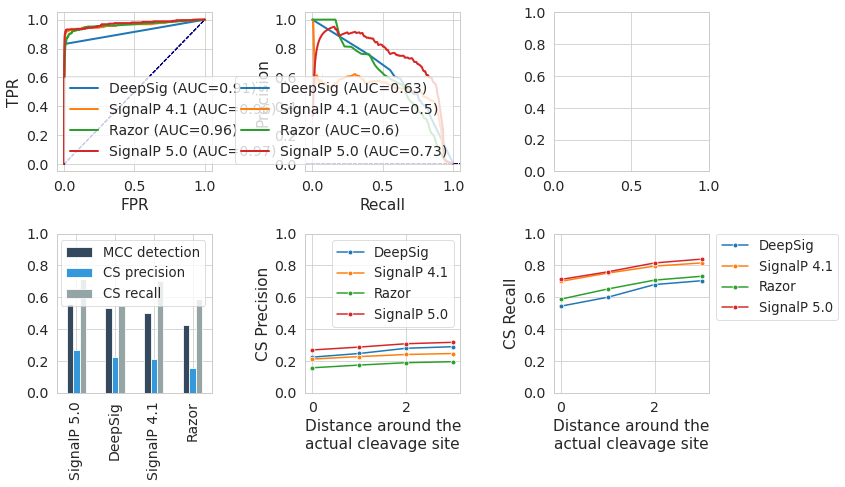

In [19]:
cols = ['Prob_DeepSig', 'Prob_SP4', 'SP_score', 'Prob_SP5']
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0']
labels = ['Label', 'Label', 'Label', 'Label']

# cols = ['Prob_DeepSig', 'D', 'Median_Toxin', 'SP(Sec/SPI)', ]
# names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0', ]
# labels = ['Label', 'Label', 'Toxin_Label', 'Label']

# new = tmp3.copy()
# new['Final_Predicted_Class'] = new['?'].apply(lambda x: 1 if x == 'Y' else 0)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7),)
axes = ax.flatten()

for i, v in enumerate(cols):

    preds = new[v].fillna(0)
    y = new[labels[i]]

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=axes[0], lw=2)
    #baseline
    axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=axes[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    axes[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')



    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')


# fig.tight_layout()
# # print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);



barplt = pd.DataFrame(columns=['MCC detection', 'CS precision', 'CS recall'],\
                      index=['Razor', 'SignalP 4.1', 'SignalP 5.0','DeepSig'])
# barplt.loc['RAZOR'] = [np.max(mcc), csp['CS Precision'].cumsum().round(3)[0], css['CS Recall'].cumsum().round(3)[0]]
barplt.loc['Razor'] = [mcc_df.loc['MCC', 'Razor'], \
                       cleavage_precision[0]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[0]['CS Recall'].cumsum().round(3)[0]]


barplt.loc['SignalP 4.1'] = [mcc_df.loc['MCC', 'SignalP 4.1'], \
                       cleavage_precision[1]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[1]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['SignalP 5.0'] = [mcc_df.loc['MCC', 'SignalP 5.0'], \
                       cleavage_precision[2]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[2]['CS Recall'].cumsum().round(3)[0]]
# barplt.loc['SignalP 6.0'] = [mcc_df.loc['MCC', 'SignalP 6.0'], \
#                        cleavage_precision[3]['CS Precision'].cumsum().round(3)[0], \
#                        cleavage_recall[3]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['DeepSig'] = [mcc_df.loc['MCC', 'DeepSig'], \
                       cleavage_precision[3]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[3]['CS Recall'].cumsum().round(3)[0]]
# barplt.loc['DeepSig'] = [0.819, 0.604, 0.624]

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),)
sns.set_context("paper", font_scale=1.5)
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]


# sns.set_palette(flatui)
barplt.sort_values(ascending=False, by='MCC detection').plot(kind='bar', \
                                                                ax=axes[3], \
                                                                color=["#34495e", "#3498db", "#95a5a6",],\
                                                            )#.legend(loc='lower left', facecolor='white', framealpha=1);


axes[3].set(ylim=(0.0, 1))

# razor 0 signalp4 1 signalp5 2 signalp6 3 deepsig 4
# deepsig signalp4 razor signalp5 signalp6
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[3]['CS Precision'].cumsum()[:4],\
             label='DeepSig', ax=axes[4], lw=1.5, marker="o",)
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[1]['CS Precision'].cumsum()[:4], \
             label='SignalP 4.1', ax=axes[4], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[0]['CS Precision'].cumsum()[:4],\
             label='Razor', ax=axes[4], lw=1.5, marker="o",)# color='black' )
# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.671, 0.702, 0.732, 0.732], color=flatui[1], ax=ax[1], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[2]['CS Precision'].cumsum()[:4],\
             label='SignalP 5.0', ax=axes[4], lw=1.5, marker="o",)
# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
#              y=cleavage_precision[3]['CS Precision'].cumsum()[:4],\
#              label='SignalP 6.0',  ax=axes[4], lw=1.5, marker="o")


# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.604, 0.631, 0.668, 0.700], color=flatui[3], ax=ax[1], lw=1.5, marker="o")
axes[4].set(ylim=(0.0, 1))
# 

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[3]['CS Recall'].cumsum()[:4],\
             label='DeepSig', ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[1]['CS Recall'].cumsum()[:4],\
             label='SignalP 4.1',  ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[0]['CS Recall'].cumsum()[:4], ax=axes[5],\
              lw=1.5, label='Razor', marker="o") #color='black',  
# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.729, 0.762, 0.795, 0.833], label='SignalP 5.0', color=flatui[1], ax=ax[2], lw=1.5, marker="o")

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[2]['CS Recall'].cumsum()[:4],\
             label='SignalP 5.0', ax=axes[5], lw=1.5, marker="o")
# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
#              y=cleavage_recall[3]['CS Recall'].cumsum()[:4],\
#              label='SignalP 6.0', ax=axes[5], lw=1.5, marker="o")

# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.624, 0.652, 0.690, 0.724], label='DeepSig', color=flatui[3], ax=ax[2], lw=1.5, marker="o")
axes[5].set(ylim=(0.0, 1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.tight_layout();
plt.savefig('../figs/benchmarking_sp5_data.pdf',  bbox_inches='tight', pad_inches=0)

In [20]:
barplt

,MCC detection,CS precision,CS recall
Razor,0.422547,0.156,0.588
SignalP 4.1,0.499472,0.211,0.7
SignalP 5.0,0.557103,0.268,0.712
DeepSig,0.529959,0.223,0.544


In [21]:
clsr = ['Razor','SignalP4.1','SignalP5','DeepSig']

for i in range(0,4):
    print(clsr[i])
    print(cleavage_precision[i]['CS Precision'].cumsum().round(3))

Razor
0    0.156
1    0.173
2    0.188
3    0.195
Name: CS Precision, dtype: float64
SignalP4.1
0    0.211
1    0.227
2    0.240
3    0.246
Name: CS Precision, dtype: float64
SignalP5
0    0.268
1    0.287
2    0.308
3    0.317
Name: CS Precision, dtype: float64
DeepSig
0    0.223
1    0.246
2    0.279
3    0.289
Name: CS Precision, dtype: float64


In [22]:
clsr = ['Razor','SignalP4.1','SignalP5','DeepSig']
for i in range(0,4):
    print(clsr[i])
    print(cleavage_recall[i]['CS Recall'].cumsum().round(3))

Razor
0    0.588
1    0.652
2    0.708
3    0.732
Name: CS Recall, dtype: float64
SignalP4.1
0    0.700
1    0.752
2    0.796
3    0.816
Name: CS Recall, dtype: float64
SignalP5
0    0.712
1    0.760
2    0.816
3    0.840
Name: CS Recall, dtype: float64
DeepSig
0    0.544
1    0.600
2    0.680
3    0.704
Name: CS Recall, dtype: float64


In [23]:
new = pd.merge(new_toxins_nontoxins[['Entry']], new, on='Entry')
tox_sp = new[(new.Label==1) & (new.Toxin==1)].copy()
tox_sp['Label'] = 1

# toxic_clstr = pd.read_csv('../results/output.distmat', sep='\s+', skiprows=1, header=None)[[0]]
# toxic_clstr.columns = ['Entry']
# tox_sp = pd.merge(toxic_clstr, tox_sp, on='Entry')

new_neg = new[new['Label'] == 0]
new = pd.concat([tox_sp, new_neg]).drop_duplicates('Entry')

In [24]:
new.Label.value_counts()

0    51950
1       49
Name: Label, dtype: int64

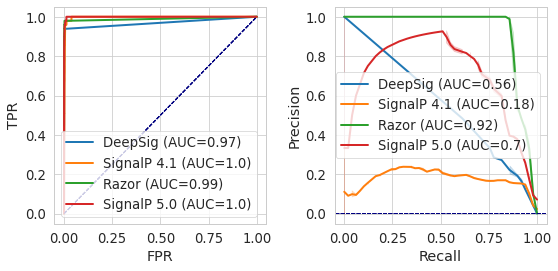

In [25]:
cols = ['Prob_DeepSig', 'Prob_SP4', 'Toxin_scores_Median', 'Prob_SP5']
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0']
labels = ['Label', 'Label', 'Label', 'Label']


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),)

for i, v in enumerate(cols):

    preds = new[v].fillna(0)
    y = new[labels[i]]

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=ax[0], lw=2)
    #baseline
    ax[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=ax[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    ax[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')



    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')


fig.tight_layout()
# print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);

In [26]:
new['Preds_Toxin_Razor'] = new.Toxin_Scores.str.replace('\[|\]','',regex=True).str.split(', ')\
.apply(lambda x: 0 if np.min(np.array(x).astype(np.float64)) <= 0.33 else 1)

In [27]:
new['Preds_Toxin_Razor'].value_counts()

0    51941
1       58
Name: Preds_Toxin_Razor, dtype: int64

<AxesSubplot:>

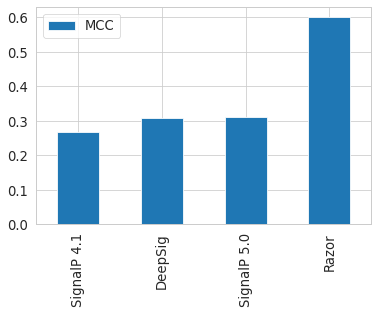

In [28]:
for_mcc = ['Preds_Toxin_Razor', 'Preds_SP4', 'Preds_SP5', 'Preds_DeepSig']
mcc_df = pd.DataFrame(columns=['Razor', 'SignalP 4.1', 'SignalP 5.0', 'DeepSig'], index=['MCC'])
labels = ['Label', 'Label', 'Label', 'Label']
# new = tmp3.copy()

for i, v in enumerate(mcc_df.columns):
    mcc_df.loc['MCC', v] = matthews_corrcoef(new[labels[i]], new[for_mcc[i]])

mcc_df.transpose().sort_values(by='MCC').plot(kind='bar')

In [29]:
mcc_df

,Razor,SignalP 4.1,SignalP 5.0,DeepSig
MCC,0.59985,0.267746,0.310644,0.30945


In [30]:
# new = tmp3.copy()

cleavage_precision = []
cleavage_recall = []


# Razor
new['Diff'] = np.abs(new['Cleav'] - new['Cleavage after residue'])
false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_Toxin_Razor'] == 1].copy()
true_n = false[false['Preds_Toxin_Razor'] == 0].copy()

false_n = true[true['Preds_Toxin_Razor'] == 0].copy()
true_p = true[true['Preds_Toxin_Razor'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_Toxin_Razor'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# SignalP4
new['Diff'] = np.abs(new['Cleav_SP4']  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_SP4'] == 1].copy()
true_n = false[false['Preds_SP4'] == 0].copy()

false_n = true[true['Preds_SP4'] == 0].copy()
true_p = true[true['Preds_SP4'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_SP4'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# SignalP5
new['Diff'] = np.abs(new['Cleav_SP5']  - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_SP5'] == 1].copy()
true_n = false[false['Preds_SP5'] == 0].copy()

false_n = true[true['Preds_SP5'] == 0].copy()
true_p = true[true['Preds_SP5'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_SP5'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)



# # SignalP6
# new['Diff'] = np.abs(new['Cleav_SP6']  - new['Cleav'])

# false = new[new['Label'] == 0].copy()
# true = new[new['Label'] == 1].copy()

# false_p = false[false['Preds_SP6'] == 1].copy()
# true_n = false[false['Preds_SP6'] == 0].copy()

# false_n = true[true['Preds_SP6'] == 0].copy()
# true_p = true[true['Preds_SP6'] == 1].copy()


# csS_ = true_p.Diff.value_counts()
# csp = pd.DataFrame()
# csp['Distance around the\nactual cleavage site'] = csS_.index.values
# csp['CS Precision'] = csS_.values/(new[new['Preds_SP6'] == 1].shape[0]) #true_p.shape[0]
# csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
# csp = csp.reset_index(drop=True)


# csS_ = true_p.Diff.value_counts()
# css = pd.DataFrame()
# css['Distance around the\nactual cleavage site'] = csS_.index.values
# css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
# css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
# css = css.reset_index(drop=True)


# blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2], 
#               'CS Precision':[0,0,0]})
# csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
# blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2], 
#               'CS Recall':[0,0,0]})
# css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


# cleavage_precision.append(csp)
# cleavage_recall.append(css)



# DeepSig
new['Diff'] = np.abs(new['Cleav_DeepSig'] - new['Cleav'])

false = new[new['Label'] == 0].copy()
true = new[new['Label'] == 1].copy()

false_p = false[false['Preds_DeepSig'] == 1].copy()
true_n = false[false['Preds_DeepSig'] == 0].copy()

false_n = true[true['Preds_DeepSig'] == 0].copy()
true_p = true[true['Preds_DeepSig'] == 1].copy()


csS_ = true_p.Diff.value_counts()
csp = pd.DataFrame()
csp['Distance around the\nactual cleavage site'] = csS_.index.values
csp['CS Precision'] = csS_.values/(new[new['Preds_DeepSig'] == 1].shape[0]) #true_p.shape[0]
csp.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
csp = csp.reset_index(drop=True)


csS_ = true_p.Diff.value_counts()
css = pd.DataFrame()
css['Distance around the\nactual cleavage site'] = csS_.index.values
css['CS Recall'] = csS_.values/new.Label.value_counts()[1]
css.sort_values(by='Distance around the\nactual cleavage site', inplace=True)
css = css.reset_index(drop=True)


blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Precision':[np.nan,np.nan,np.nan,np.nan]})
csp = pd.concat([csp[csp['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')
blk_df = pd.DataFrame({'Distance around the\nactual cleavage site':[0,1,2,3], 
              'CS Recall':[np.nan,np.nan,np.nan,np.nan]})
css = pd.concat([css[css['Distance around the\nactual cleavage site']<=3], blk_df]).drop_duplicates('Distance around the\nactual cleavage site')


cleavage_precision.append(csp)
cleavage_recall.append(css)

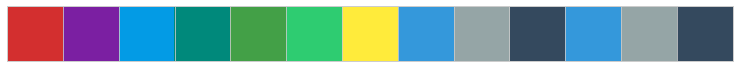

In [31]:
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]
sns.palplot(flatui)

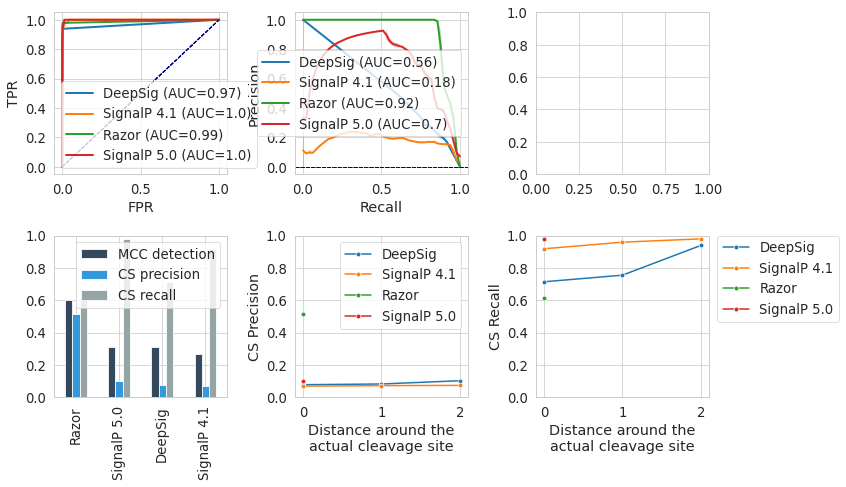

In [32]:
cols = ['Prob_DeepSig', 'Prob_SP4', 'Toxin_scores_Median', 'Prob_SP5', ]
names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0', ]
labels = ['Label', 'Label', 'Label', 'Label', 'Label']

# cols = ['Prob_DeepSig', 'D', 'Median_Toxin', 'SP(Sec/SPI)', ]
# names = ['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0', ]
# labels = ['Label', 'Label', 'Toxin_Label', 'Label']

# new = tmp3.copy()
# new['Final_Predicted_Class'] = new['?'].apply(lambda x: 1 if x == 'Y' else 0)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7),)
axes = ax.flatten()

for i, v in enumerate(cols):

    preds = new[v].fillna(0)
    y = new[labels[i]]

    #Precision, recall
    precision, recall, _ = precision_recall_curve(y, preds, )
    lr_auc = auc(recall, precision)


    #ROC

    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)





    sns.lineplot(x=fpr, y=tpr, label='{} (AUC={})'.format(names[i], round(roc_auc, 2)), ax=axes[0], lw=2)
    #baseline
    axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    sns.lineplot(x=recall, y=precision, label='{} (AUC={})'.format(names[i], round(lr_auc, 2)), ax=axes[1], lw=2)
    #baseline
    baseline = new.Label.value_counts()[1]/new.shape[0]

    axes[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')



    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')


# fig.tight_layout()
# # print('MCC = {}'.format(matthews_corrcoef(y, new['Final_Predicted_Class'])))
# plt.savefig('../figs/Benchmark_SP_new_data.pdf', bbox_inches='tight', pad_inches=0);



barplt = pd.DataFrame(columns=['MCC detection', 'CS precision', 'CS recall'],\
                      index=['DeepSig', 'SignalP 4.1', 'Razor', 'SignalP 5.0'])
# barplt.loc['RAZOR'] = [np.max(mcc), csp['CS Precision'].cumsum().round(3)[0], css['CS Recall'].cumsum().round(3)[0]]
barplt.loc['Razor'] = [mcc_df.loc['MCC', 'Razor'], \
                       cleavage_precision[0]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[0]['CS Recall'].cumsum().round(3)[0]]


barplt.loc['SignalP 4.1'] = [mcc_df.loc['MCC', 'SignalP 4.1'], \
                       cleavage_precision[1]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[1]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['SignalP 5.0'] = [mcc_df.loc['MCC', 'SignalP 5.0'], \
                       cleavage_precision[2]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[2]['CS Recall'].cumsum().round(3)[0]]
# barplt.loc['SignalP 6.0'] = [mcc_df.loc['MCC', 'SignalP 6.0'], \
#                        cleavage_precision[3]['CS Precision'].cumsum().round(3)[0], \
#                        cleavage_recall[3]['CS Recall'].cumsum().round(3)[0]]
barplt.loc['DeepSig'] = [mcc_df.loc['MCC', 'DeepSig'], \
                       cleavage_precision[3]['CS Precision'].cumsum().round(3)[0], \
                       cleavage_recall[3]['CS Recall'].cumsum().round(3)[0]]
# barplt.loc['DeepSig'] = [0.819, 0.604, 0.624]

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),)
sns.set_context("paper", font_scale=1.5)
flatui = ["#d32f2f", "#7b1fa2","#039be5", "#00897b", "#43a047",  "#2ecc71" ,"#ffeb3b",  "#3498db", "#95a5a6",  "#34495e", "#3498db", "#95a5a6",  "#34495e",]


# sns.set_palette(flatui)
barplt.sort_values(ascending=False, by='MCC detection').plot(kind='bar', \
                                                                ax=axes[3], \
                                                                color=["#34495e", "#3498db", "#95a5a6",],\
                                                            )#.legend(loc='lower left', facecolor='white', framealpha=1);


axes[3].set(ylim=(0.0, 1))

# razor 0 signalp4 1 signalp5 2 signalp6 3 deepsig 4
# deepsig signalp4 razor signalp5 signalp6
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[3]['CS Precision'].cumsum()[:4],\
             label='DeepSig', ax=axes[4], lw=1.5, marker="o",)
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[1]['CS Precision'].cumsum()[:4], \
             label='SignalP 4.1', ax=axes[4], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[0]['CS Precision'].cumsum()[:4],\
             label='Razor', ax=axes[4], lw=1.5, marker="o",)# color='black' )
# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.671, 0.702, 0.732, 0.732], color=flatui[1], ax=ax[1], lw=1.5, marker="o")
sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_precision[2]['CS Precision'].cumsum()[:4],\
             label='SignalP 5.0', ax=axes[4], lw=1.5, marker="o",)
# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4],\
#              y=cleavage_precision[3]['CS Precision'].cumsum()[:4],\
#              label='SignalP 6.0',  ax=axes[4], lw=1.5, marker="o")


# sns.lineplot(x=csp['Distance around the\nactual cleavage site'][:4], y=[0.604, 0.631, 0.668, 0.700], color=flatui[3], ax=ax[1], lw=1.5, marker="o")
axes[4].set(ylim=(0.0, 1))
# 

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[3]['CS Recall'].cumsum()[:4],\
             label='DeepSig', ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[1]['CS Recall'].cumsum()[:4],\
             label='SignalP 4.1',  ax=axes[5], lw=1.5, marker="o")
sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[0]['CS Recall'].cumsum()[:4], ax=axes[5],\
              lw=1.5, label='Razor', marker="o") #color='black',  
# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.729, 0.762, 0.795, 0.833], label='SignalP 5.0', color=flatui[1], ax=ax[2], lw=1.5, marker="o")

sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
             y=cleavage_recall[2]['CS Recall'].cumsum()[:4],\
             label='SignalP 5.0', ax=axes[5], lw=1.5, marker="o")
# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4],\
#              y=cleavage_recall[3]['CS Recall'].cumsum()[:4],\
#              label='SignalP 6.0', ax=axes[5], lw=1.5, marker="o")

# sns.lineplot(x=css['Distance around the\nactual cleavage site'][:4], y=[0.624, 0.652, 0.690, 0.724], label='DeepSig', color=flatui[3], ax=ax[2], lw=1.5, marker="o")
axes[5].set(ylim=(0.0, 1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



plt.tight_layout();
plt.savefig('../figs/benchmarking_toxin_sp5_data.pdf',  bbox_inches='tight', pad_inches=0)

In [35]:
barplt

,MCC detection,CS precision,CS recall
DeepSig,0.30945,0.078,0.714
SignalP 4.1,0.267746,0.069,0.918
Razor,0.59985,0.517,0.612
SignalP 5.0,0.310644,0.099,0.98


In [33]:
clsr = ['Razor','SignalP4.1','SignalP5','DeepSig']

for i in range(0,4):
    print(clsr[i])
    print(cleavage_precision[i]['CS Precision'].cumsum().round(3))

Razor
0    0.517
1      NaN
2      NaN
3      NaN
Name: CS Precision, dtype: float64
SignalP4.1
0    0.069
1    0.073
2    0.074
3      NaN
Name: CS Precision, dtype: float64
SignalP5
0    0.099
1      NaN
2      NaN
3      NaN
Name: CS Precision, dtype: float64
DeepSig
0    0.078
1    0.083
2    0.103
3      NaN
Name: CS Precision, dtype: float64


In [34]:
for i in range(0,4):
    print(clsr[i])
    print(cleavage_recall[i]['CS Recall'].cumsum().round(3))

Razor
0    0.612
1      NaN
2      NaN
3      NaN
Name: CS Recall, dtype: float64
SignalP4.1
0    0.918
1    0.959
2    0.980
3      NaN
Name: CS Recall, dtype: float64
SignalP5
0    0.98
1     NaN
2     NaN
3     NaN
Name: CS Recall, dtype: float64
DeepSig
0    0.714
1    0.755
2    0.939
3      NaN
Name: CS Recall, dtype: float64
